# Handwritten Digit Classification 

This project implements logistic regression classifiers to recognize handwritten digits using the MNIST dataset. We start with a simplified **binary classification** task (digits 0 vs 1), then scale to **multiclass classification** (digits 0–9) on small 8x8 images, and finally train on the **full MNIST 28x28 dataset**.  

Using stochastic gradient descent (SGD) for optimization, we evaluate model performance with cross-validation and confusion matrices. Additionally, we analyze which digits are hardest to predict, evaluate generalization performance, and visualize the data and results.

Despite its simplicity, logistic regression remains a strong baseline in high-dimensional settings. This project explores its behavior across increasing task complexity and under distribution shift.



## Importing the relevant libraries

In [1]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from logistic_regression_src import ClassifierBase, plot_digits_sample


## Binary logistic regression: Digits 0 vs 1
* Training a binary logistic regression model based on a simplified version of the MNIST dataset. The dataset consists of 360 images (resolution 8x8), of which 178 are handwritten zeros and the other 182 are handwritten ones. The images are stored in `X`, while the targets (a 1 or 0) are stored in `y`.


Total number of observations: 360
Number of observations of class 0: 178
Number of observations of class 1: 182


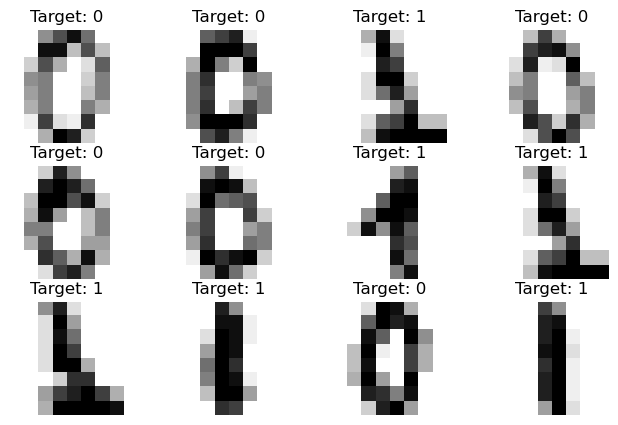

In [ ]:
# Load 8x8 digits dataset, only 0 and 1
digits = datasets.load_digits()
X = digits.images[np.logical_or(digits.target == 0, digits.target == 1)]
y = digits.target[np.logical_or(digits.target == 0, digits.target == 1)].reshape(-1, 1)
N = len(y)
K = np.unique(y).shape[0]
digits.target_names = np.unique(y).sort()

print(f"Total number of observations: {N}")
for k in range(K):
    print(f"Number of observations of class {k}: {np.sum(y == k)}")

plot_digits_sample(X, y)


### Creating a binary logistic regression classs. Stochastic gradient descent is used for training with the loss function used being negative log likelihood.

In [3]:
class BinaryLogisticRegressionClassifier(ClassifierBase):
    """
    Binary logistic regression classifier using stochastic gradient descent.

    This class implements a binary logistic regression model for classification tasks,
    using negative log likelihood as the loss function and SGD for optimization.

    Parameters
    ----------
    learning_rate : float, default=0.0001
        Learning rate for gradient descent.
    batch_size : int, default=20
        Number of samples per batch for SGD.
    epochs : int, default=3
        Number of passes over the training data.
    """

    def __init__(self, learning_rate=0.0001, batch_size=20, epochs=3):
        """
        Initialize the classifier.
        """
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.beta = None
        self.K = None

    def _flatten(self, X):
        """
        Flatten input images to 2D array.

        Returns
        -------
        np.ndarray
            Flattened data of shape (n_samples, n_features).
        """
        return X.reshape(X.shape[0], -1)
    
    def _batchify(self, X, y):
        """
        Split data into batches.

        Returns
        -------
        tuple
            Batched X and y.
        """
        n_batches = X.shape[0] // self.batch_size
        X = X[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, *X.shape[1:])
        y = y[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, 1)
        return X, y
    
    def _sigmoid(self, x):
        """
        Numerically stable sigmoid function.
        """
        out = np.where(
            x >= 0,
            1 / (1 + np.exp(-x)),
            np.exp(x) / (1 + np.exp(x))
        )
        return out.reshape(-1, 1)

    def _compute_logits(self, X_flat):
        """
        Compute logits for input data.
        """
        X_flat = np.hstack((np.ones((X_flat.shape[0], 1)), X_flat))
        return X_flat @ self.beta, X_flat

    def _compute_gradient_loss(self, X, y):
        """
        Compute gradient of the loss function.
        """
        X_flat = self._flatten(X)
        logits, X_flat_with_bias = self._compute_logits(X_flat)
        p = self._sigmoid(logits)
        grad = (p - y).flatten() @ X_flat_with_bias / X_flat.shape[0]
        return grad

    def fit(self, X, y, initialize_beta=True, verbose=False):
        """
        Fit the logistic regression model.

        Parameters
        ----------
        X : np.ndarray
            Training data.
        y : np.ndarray
            Training labels.
        initialize_beta : bool, default=True
            Whether to re-initialize model parameters.
        verbose : bool, default=False
            If True, print training accuracy after each epoch.
        """
        self.K = np.unique(y).shape[0]
        X_batched, y_batched = self._batchify(X, y)
        n_features = np.prod(X_batched.shape[2:]).item()
        if initialize_beta or self.beta is None:
            self.beta = np.random.randn(n_features + 1) * 0.01  # Small random initialization
        if verbose == True:
            print(f"Epoch {0}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")
        for epoch in range(self.epochs):
            for j, X_batch in enumerate(X_batched):
                y_batch = y_batched[j]
                gradient = self._compute_gradient_loss(X_batch, y_batch)
                self.beta -= self.learning_rate * gradient

            if verbose == True:
                print(f"Epoch {epoch+1}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Returns
        -------
        np.ndarray
            Predicted class labels.
        """
        logits, _ = self._compute_logits(self._flatten(X))
        p = self._sigmoid(logits)
        y_pred = (p > 0.5).astype(int)
        return y_pred

### Training a logistic regression model and computing its accuracy on the training set.

In [4]:
model = BinaryLogisticRegressionClassifier(learning_rate=0.0002, batch_size=20, epochs=3)
model.fit(X, y, verbose=True)

Epoch 0/3, Training accuracy: 53.33%
Epoch 1/3, Training accuracy: 99.17%
Epoch 2/3, Training accuracy: 99.44%
Epoch 3/3, Training accuracy: 99.72%


### Cross-validation to estimate model performance of the `BinaryLogisticRegressionClassifier` model.

In [5]:
model = BinaryLogisticRegressionClassifier(learning_rate=0.01, batch_size=20, epochs=3)
model.cross_validation(X, y, K_cv=5, runs=10)

(0.9986111111111111, 0.0005952380952380931)

* The cell below computes the confusion matrix using cross-validation.

In [6]:
model.confusion_matrix(X, y, K_cv=5, runs=10, class_labels=digits.target_names)

Actual class:,0,1
Predicted class:,,
0,1.0,0.0
1,0.0,1.0


## Multiclass Classification on 8×8 MNIST
* We now re-load the dataset and include all possible 10 handwritten digits.

Total number of observations: 1797
Number of observations of class 0: 178
Number of observations of class 1: 182
Number of observations of class 2: 177
Number of observations of class 3: 183
Number of observations of class 4: 181
Number of observations of class 5: 182
Number of observations of class 6: 181
Number of observations of class 7: 179
Number of observations of class 8: 174
Number of observations of class 9: 180


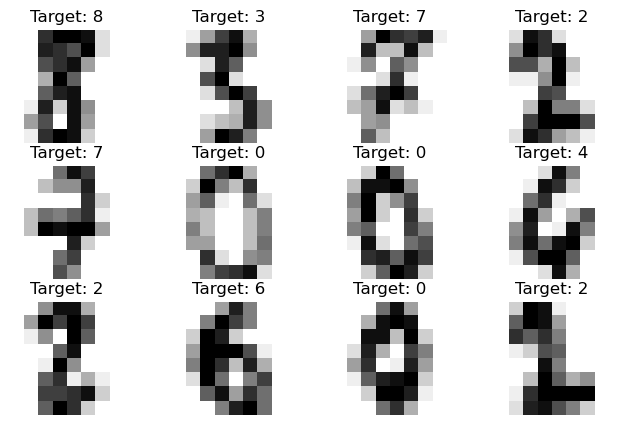

In [ ]:
# Load full 8x8 digits dataset
digits = datasets.load_digits()
X = digits.images
y = digits.target.reshape(-1, 1)
N = len(y)
K = np.unique(y).shape[0]

print(f"Total number of observations: {N}")
for k in range(K):
    print(f"Number of observations of class {k}: {np.sum(y == k)}")
    
# Visualize sample digits
plot_digits_sample(X, y)

* Creating a new class `LogisticRegressionClassifier`, that performs logistic regression on the MNIST dataset loaded in the previous cell. Since this is not a binary classification task, we use a one-hot encoded target variable and a softmax function. 



In [8]:
class LogisticRegressionClassifier(ClassifierBase):
    """
    Multiclass logistic regression classifier using stochastic gradient descent.

    This class implements a multiclass logistic regression model for classification tasks,
    using cross-entropy (negative log-likelihood) as the loss function and SGD for optimization.

    Parameters
    ----------
    learning_rate : float, default=0.0001
        Learning rate for gradient descent.
    batch_size : int, default=20
        Number of samples per batch for SGD.
    epochs : int, default=3
        Number of passes over the training data.
    """

    def __init__(self, learning_rate=0.0001, batch_size=20, epochs=3):
        """
        Initialize the classifier.
        """
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.beta = None
        self.K = None

    def _flatten(self, X):
        """
        Flatten input images to 2D array.

        Returns
        -------
        np.ndarray
            Flattened data of shape (n_samples, n_features).
        """
        return X.reshape(X.shape[0], -1)
    
    def _batchify(self, X, y):
        """
        Split data into batches.

        Returns
        -------
        tuple
            Batched X and y.
        """
        n_batches = X.shape[0] // self.batch_size
        X = X[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, *X.shape[1:])
        y = y[:n_batches*self.batch_size].reshape(n_batches, self.batch_size, *y.shape[1:])
        return X, y

    def _softmax(self, z):
        """
        Softmax function for multiclass probabilities.

        Instead of using sigmoid function in binary case.
        """
        z_exp = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
        return z_exp / np.sum(z_exp, axis=1, keepdims=True)

    def _compute_logits(self, X_flat):
        """
        Compute logits for input data.
        """
        X_flat = np.hstack((np.ones((X_flat.shape[0], 1)), X_flat))  # add bias term
        return X_flat @ self.beta, X_flat

    def _compute_gradient_loss(self, X, y):
        """
        Compute gradient of the multiclass cross-entropy loss.

        Instead of using (p - y) for sigmoid.
        """
        X_flat = self._flatten(X)
        logits, X_flat_with_bias = self._compute_logits(X_flat)
        p = self._softmax(logits)
        grad = X_flat_with_bias.T @ (p - y) / X_flat.shape[0]
        return grad

    def fit(self, X, y, initialize_beta=True, verbose=False):
        """
        Fit the logistic regression model.

        Parameters
        ----------
        X : np.ndarray
            Training data.
        y : np.ndarray
            Training labels (integers 0..K-1). Will be one-hot encoded internally.
        initialize_beta : bool, default=True
            Whether to re-initialize model parameters.
        verbose : bool, default=False
            If True, print training accuracy after each epoch.
        """
        # Convert integer labels to one-hot encoding
        self.K = np.unique(y).shape[0]
        y_onehot = np.eye(self.K)[y.flatten()]  # shape (n_samples, K)

        X_batched, y_batched = self._batchify(X, y_onehot)
        n_features = np.prod(X_batched.shape[2:]).item()
        if initialize_beta or self.beta is None:
            # Beta now has shape (n_features + 1, K) instead of (n_features + 1,)
            self.beta = np.random.randn(n_features + 1, self.K) * 0.01

        if verbose:
            print(f"Epoch {0}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")

        for epoch in range(self.epochs):
            for j, X_batch in enumerate(X_batched):
                y_batch = y_batched[j]
                gradient = self._compute_gradient_loss(X_batch, y_batch)
                self.beta -= self.learning_rate * gradient

            if verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Training accuracy: {self.score(X, y):.2%}")

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Instead of using the binary classifier where we thresholded probabilities at 0.5.
        """
        logits, _ = self._compute_logits(self._flatten(X))
        p = self._softmax(logits)
        y_pred = np.argmax(p, axis=1).reshape(-1, 1)
        return y_pred


### Training the logistic regression classifier
* It learns to predict the training data during trainin, out-of-sample data using cross-validation but also using a confusion matrix

In [9]:
# Fresh instantiation
model_multi = LogisticRegressionClassifier(learning_rate=0.01, batch_size=20, epochs=10)

# Fit on full MNIST training data (all 10 digits)
model_multi.fit(X, y, verbose=True)

# Confusion matrix (5-fold CV, repeated 10 times)
model_multi.confusion_matrix(X, y, K_cv=5, runs=10, class_labels=np.arange(10))


Epoch 0/10, Training accuracy: 9.79%
Epoch 1/10, Training accuracy: 92.88%
Epoch 2/10, Training accuracy: 93.93%
Epoch 3/10, Training accuracy: 94.21%
Epoch 4/10, Training accuracy: 94.16%
Epoch 5/10, Training accuracy: 94.44%
Epoch 6/10, Training accuracy: 94.55%
Epoch 7/10, Training accuracy: 94.82%
Epoch 8/10, Training accuracy: 95.05%
Epoch 9/10, Training accuracy: 95.33%
Epoch 10/10, Training accuracy: 95.49%


Actual class:,0,1,2,3,4,5,6,7,8,9
Predicted class:,,,,,,,,,,
0,1.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00
1,0.0,0.97,0.02,0.00,0.04,0.01,0.02,0.00,0.15,0.02
2,0.0,0.00,0.95,0.01,0.00,0.01,0.00,0.00,0.01,0.00
3,0.0,0.00,0.02,0.97,0.00,0.01,0.00,0.01,0.08,0.01
4,0.0,0.00,0.00,0.00,0.91,0.00,0.00,0.00,0.00,0.00
5,0.0,0.00,0.00,0.00,0.00,0.91,0.00,0.00,0.01,0.01
6,0.0,0.00,0.00,0.00,0.02,0.01,0.97,0.00,0.01,0.00
7,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.97,0.01,0.00
8,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.68,0.00


* The 8th diagonal of the confusion matrix is the lowest, meaning that the digit '8' is the hardest to predict correctly. From the data, the digit 8 was only correctly predicted 68% of the time, whereas for the other digits the success rate is above 90%. Looking at the other rows when the actual class is 8, it was incorrectly classified as '1' 15% of the time and '3' 8% of the time. This makes sense especially in low-resolution images where the numbers have some visual similarities.



## Scaling to Full MNIST (28×28)

In [10]:
import os
from sklearn.datasets import fetch_openml
import numpy as np

# Define MNIST subfolder inside your existing data folder
mnist_folder = "data/mnist"
if not os.path.exists(mnist_folder):
    os.makedirs(mnist_folder)

# Download MNIST dataset (original 28x28 resolution) into the subfolder
mnist = fetch_openml('mnist_784', version=1, cache=True, data_home=mnist_folder)

# Extract data and labels
X = mnist.data.values.astype(np.float32)  # shape (70000, 784)
y = mnist.target.to_numpy().astype(int).reshape(-1, 1)  # convert Series to NumPy and reshape

# Reshape into 28x28 images
X_images = X.reshape(-1, 28, 28)

# Split into training (first 60000) and test (last 10000)
X_train = X_images[:60000]
y_train = y[:60000]

X_test = X_images[60000:]
y_test = y[60000:]

# Quick check
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (60000, 28, 28), (60000, 1)
Test set: (10000, 28, 28), (10000, 1)


In [11]:
# Instantiate the multiclass logistic regression classifier
# Use a slightly larger batch size for faster training on the full MNIST dataset
mnist_model = LogisticRegressionClassifier(learning_rate=0.01, batch_size=200, epochs=10)

# Fit the model on the full MNIST training set
mnist_model.fit(X_train, y_train, verbose=True)

# Compute training accuracy
train_acc = mnist_model.score(X_train, y_train)
print(f"Training accuracy: {train_acc:.2%}")

# Compute test accuracy
test_acc = mnist_model.score(X_test, y_test)
print(f"Test accuracy: {test_acc:.2%}")


Epoch 0/10, Training accuracy: 10.39%
Epoch 1/10, Training accuracy: 88.00%
Epoch 2/10, Training accuracy: 88.45%
Epoch 3/10, Training accuracy: 85.84%
Epoch 4/10, Training accuracy: 88.46%
Epoch 5/10, Training accuracy: 89.23%
Epoch 6/10, Training accuracy: 88.01%
Epoch 7/10, Training accuracy: 87.75%
Epoch 8/10, Training accuracy: 88.95%
Epoch 9/10, Training accuracy: 87.38%
Epoch 10/10, Training accuracy: 88.12%
Training accuracy: 88.12%
Test accuracy: 87.56%


* Verifying which of the 10 digits are the hardest to predict using the test set.

In [12]:
hardest_digit = np.argmin([mnist_model.score(X_test[y_test.flatten() == k], y_test[y_test.flatten() == k]) for k in range(10)])
print(hardest_digit)


8


* While logistic regression cannot model nonlinear pixel interactions, it provides a strong linear baseline with competitive accuracy.

## Robust Generalization under Spurious Correlation and Distribution Shift

The dataset consists of 1,000 observations with 2,000 continuous features, a b
This part of the project focuses on a high-dimensional binary classification problem in which the training data exhibits a spurious correlation between the target variable and an auxiliary attribute.

The dataset contains 1,000 observations with 2,000 continuous input features, a binary target variable y, and an additional binary attribute a. While  a is correlated with𝑦 y in the training data, it is not causally related to the prediction task and may change its relationship with y over time. It is never used for prediction, but serves to test whether models learn invariant structure in X rather than sample-specific shortcuts.

The objective is to train a model that generalizes well under this distribution shift, emphasizing robustness to spurious correlations rather than reliance on shortcuts present in the training data. This setup mirrors real-world settings where correlations present in historical data may vary over time. 


In [ ]:
class DataSimple():
    """Simplified Data class without DGP reference, noise and masks."""
    
    def __init__(self, y: np.ndarray, a: np.ndarray, x: np.ndarray, random_state: int = None):
        """
        Initialize the DataSimple object.

        Args:
            y: Binary outcome variable
            a: Attribute variable
            x: Composite variable
            random_state: Seed for reproducibility
        """
        self.n = y.shape[0]
        self.y = y
        self.a = a
        self.X = x
        self.random_state = random_state

    def get_shapes(self) -> dict:
        """Return the shapes of y, a, and x."""
        return {
            'y_shape': self.y.shape,
            'a_shape': self.a.shape,
            'x_shape': self.X.shape
        }

with open('data/data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)

### Analysis


#### Exploratory Analysis and Model Selection

To begin, I applied PCA on standardized features to reduce the 2,000-dimensional input space to 2 principal components, capturing the directions of largest variance. I then created two scatter plots: one colored by the target variable `y`, and one by the auxiliary attribute `a`. This visualization helps identify the presence of spurious correlations in the data.





Shapes:
X: (1000, 2000), y: (1000,), a: (1000,)

Label distribution:
y=0: 506, y=1: 494

Attribute distribution:
a=0: 525, a=1: 475


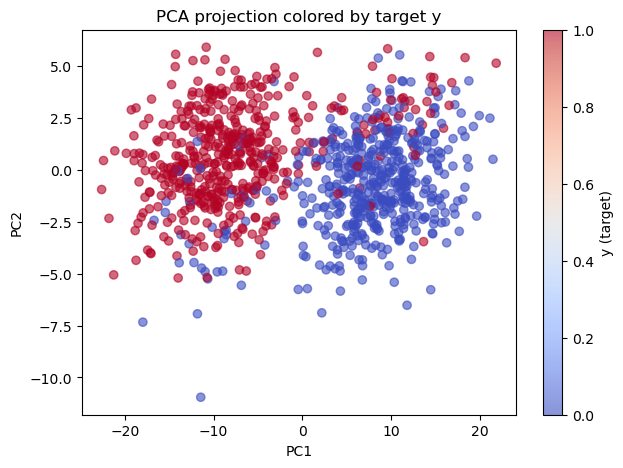

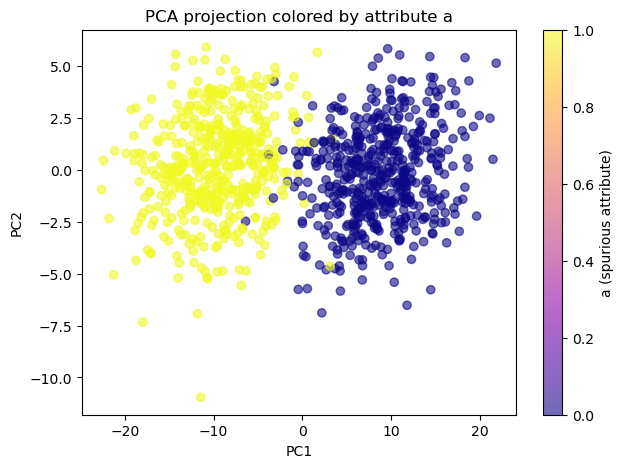

In [15]:
# Data overview
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract data
X = data_train.X
y = data_train.y.flatten()
a = data_train.a.flatten()

print("Shapes:")
print(f"X: {X.shape}, y: {y.shape}, a: {a.shape}")
print("\nLabel distribution:")
print(f"y=0: {np.sum(y==0)}, y=1: {np.sum(y==1)}")
print("\nAttribute distribution:")
print(f"a=0: {np.sum(a==0)}, a=1: {np.sum(a==1)}")

# PCA visualization
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA projection colored by target y")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, label='y (target)')
plt.show()

# PCA plot colored by attribute a
plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=a, cmap='plasma', alpha=0.6)
plt.title("PCA projection colored by attribute a")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, label='a (spurious attribute)')
plt.show()


##### From the plot colored by `y`, we observe a general separation between classes, although some overlap exists, indicating that the classes are not perfectly linearly separable. The plot colored by `a` exhibits a similar separation pattern, demonstrating that `a` is strongly correlated with `y` in the training data. This confirms the presence of a spurious correlation.

##### A model trained naively on this data may overfit to the spurious correlation, leading to poor generalization on unseen data where the correlation between `a` and `y` differs. To mitigate this, I consider logistic regression as a baseline, with potential variations including L2 (Ridge) and L1 (Lasso) regularization to handle the high-dimensional feature space. An alternative approach is to apply PCA to reduce dimensionality before fitting logistic regression. These strategies aim to improve generalization while controlling for overfitting in this high-dimensional setting.

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Extract data
X = data_train.X
y = data_train.y.ravel()
a = data_train.a.ravel()

# Basic info
print("Shapes:", X.shape, y.shape)
print("Proportion of class 1 in y:", np.mean(y))
print("Proportion of a=1:", np.mean(a))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Shapes: (1000, 2000) (1000,)
Proportion of class 1 in y: 0.494
Proportion of a=1: 0.475


In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to be used
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=2000))
    ]),
    "Ridge (L2)": Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', LogisticRegression(penalty='l2', solver='saga', max_iter=2000))
    ]),
    "Lasso (L1) + PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),  # reduce dimensionality to help convergence
        ('lasso', LogisticRegression(penalty='l1', solver='saga', max_iter=2000, tol=1e-4))
    ]),
    "PCA + Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('logreg', LogisticRegression(max_iter=2000))
    ])
}

# Run cross-validation and print results
results = {}
for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    results[name] = (scores.mean(), scores.std())
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression: 0.9340 ± 0.0111
Ridge (L2): 0.9300 ± 0.0114
Lasso (L1) + PCA: 0.9150 ± 0.0184
PCA + Logistic Regression: 0.9170 ± 0.0169


The above results show the four different models mentioned previously using 5-fold cross-validation. The mean accuracies are printed along with the standard deviation.

Plain logistic regression achieves the highest mean accuracy, closely followed by Ridge (L2) regularization. PCA-based approaches slightly reduce predictive performance, suggesting that dimensionality reduction discards some features that are informative for predicting `y`. The low standard deviations indicate that all models are stable across folds.

Overall, logistic regression with standardized features provides the best balance of accuracy and simplicity for this dataset, and is therefore selected as the preferred model.


### Final Model Selection

Based on the cross-validation results, **logistic regression with standardized features** was selected as the best-performing model. It achieves the highest mean accuracy, is stable across folds, and is simple to implement in high-dimensional settings.

The selected model is encapsulated in a `Model` class with the following functionality:

- `fit(data)`: trains the model using the input features `X` and target `y` from a `Data` object.  
- `predict(X)`: predicts the target variable for new observations using the learned model.




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

class Model():
    """
    Best model for predicting y using X.
    Uses Logistic Regression with standardized features.
    """
    
    def __init__(self):  # Pipeline: standardize features, then apply logistic regression
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(max_iter=2000))
        ])
    
    def fit(self, data):
        """
        Fit the model using the features and target from a Data object.
        """
        X = data.X
        y = data.y.ravel()
        self.pipeline.fit(X, y)
    
    def predict(self, X): #Predict target variable for new observations
        return self.pipeline.predict(X)



### Out-of-Distribution Generalization Evaluation
Next, we evaluate the model's performance on an unseen test set, which may have a **different correlation structure** between `y` and the spurious attribute `a`. This checks whether the model generalizes well even when the spurious correlation changes, emphasizing robustness under distribution shift.


In [ ]:


# Load data
with open('data/data_train.pkl', 'rb') as f: # training data
    data_train = pickle.load(f)
try:
    with open('data/data_test.pkl', 'rb') as f: # test data, can be any available test set
        data_test = pickle.load(f)
except FileNotFoundError:
    with open('data/data_test_FAKE.pkl', 'rb') as f:
        data_test = pickle.load(f)

# Custom model parameters
try:
    model_kwargs
except NameError:
    model_kwargs = {}

# Train custom model
model = Model(**model_kwargs)
model.fit(data_train)

# Predict on test set
y_pred = model.predict(data_test.X)
print("Accuracy (default):   ", np.mean(y_pred == data_test.y))

# # Predict one-by-one to verify consistency
errors = []
for i in range(data_test.X.shape[0]):
    y_pred = model.predict(data_test.X[i].reshape(1, -1))
    errors.append(y_pred == data_test.y[i])
print("Accuracy (one-by-one):", np.mean(errors))

Accuracy (default):    0.50032
Accuracy (one-by-one): 0.516
